In [84]:
import sys
sys.path.append('../bayesopt')

import read_agg_data
import torch
import torch.nn as nn
import torch.autograd as auto
import torch.optim as optim

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import math
import pdb

dvfs_dict = {
    "0xc00" :  1.2,
    "0xd00" :  1.3,
    "0xe00" :  1.4,
    "0xf00" :  1.5,
    "0x1000" : 1.6,
    "0x1100" : 1.7,
    "0x1200" : 1.8,
    "0x1300" : 1.9,
    "0x1400" : 2.0,
    "0x1500" : 2.1,
    "0x1600" : 2.2,
    "0x1700" : 2.3,
    "0x1800" : 2.4,
    "0x1900" : 2.5,
    "0x1a00" : 2.6,
    "0x1b00" : 2.7,
    "0x1c00" : 2.8,
    "0x1d00" : 2.9,
    "0xffff" : 3.0,
}

In [85]:
#df_comb, _, _ = read_agg_data.start_analysis('mcd') #DATA
#df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: int(x, base=16))

df_comb = pd.read_csv('/home/handong/jupyter/jupyter-notebooks/nic-tuning-experiments/bayesopt/summary_data/mcdsilo_combined.csv', sep=' ')
df_comb = df_comb[(df_comb['rapl'] == 135)]
df_comb = df_comb[(df_comb['read_99th'] >40) & (df_comb['read_99th'] <= 500)]

df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: dvfs_dict[x])
df_comb = df_comb[(df_comb['itr']!=1) & (df_comb['dvfs']!=65535)] #filter out linux dynamic
df_comb['QPS'] = df_comb['target_QPS']

print(df_comb.columns, df_comb['QPS'].unique(), df_comb.shape[0], df_comb['rapl'].unique())
print(df_comb['itr'].unique())
print(df_comb['dvfs'].unique())

# df_comb['dvfs'] = df_comb['dvfs'].astype(float) / df_comb['dvfs'].min()
# print(df_comb['dvfs'].unique())
# df_comb['itr'] = df_comb['itr'].astype(float) / df_comb['itr'].min()
# print(df_comb['itr'].unique())
#print(10**6)

Index(['sys', 'i', 'itr', 'dvfs', 'rapl', 'read_5th', 'read_10th', 'read_50th',
       'read_90th', 'read_95th', 'read_99th', 'measure_QPS', 'target_QPS',
       'time', 'joules', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes',
       'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'c1', 'c1e', 'c3',
       'c6', 'c7', 'num_interrupts', 'QPS'],
      dtype='object') [ 50000 100000 200000 300000] 772 [135]
[666   2   4  10  20  30  40  50 100 200   8 300]
[1.2 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 2.  2.4 2.6 2.8]


In [41]:
for itr in [50, 100, 200, 300]:
    for sys in ['ebbrt_tuned', 'linux_tuned']:
        for qps in [50000, 100000, 200000]:
            df = df_comb[(df_comb['sys']==sys) & (df_comb['QPS'] == qps)].copy()
            #print(df.shape[0])
            print(df['joules'].max())
            df['joules_per_interrupt'] = df['joules']/df['num_interrupts']
            df = df[['joules_per_interrupt','itr', 'dvfs', 'read_99th', 'num_interrupts']]
            #print(df.shape[0])
            #print('')
            
            dfi = df[df['itr']==itr]
            #dfi = dfi.drop_duplicates(subset = ["itr", "dvfs"])
            #dfi['joules_mean'] = dfi['joules_mean']/dfi['joules_mean'].max()
            #print(dfi.diff())
            print('*******', sys, itr, qps)
            print(dfi.sort_values(by=['dvfs']))
            #print(dfi.sort_values(by=['dvfs']).diff())
            print('')
            #plt.plot(dfi['dvfs'], dfi['joules_per_interrupt'])
            #print(dfi)

1884.97
******* ebbrt_tuned 50 50000
     joules_per_interrupt  itr  dvfs  read_99th  num_interrupts
308              0.000760   50   2.4      207.6         2286601
309              0.000763   50   2.4      209.1         2281185
169              0.000777   50   2.5      216.8         2283760
347              0.000768   50   2.5      204.9         2288942
348              0.000773   50   2.5      206.7         2286974
188              0.000793   50   2.6      214.5         2279336
725              0.000781   50   2.6      200.8         2281031
391              0.000802   50   2.7      213.0         2278641
392              0.000798   50   2.7      209.3         2285971
785              0.000802   50   2.7      215.2         2282442
485              0.000816   50   2.8      213.2         2279115
486              0.000818   50   2.8      213.7         2276347
256              0.000821   50   2.9      201.6         2294758
605              0.000818   50   2.9      202.5         2292782
606

     joules_per_interrupt  itr  dvfs  read_99th  num_interrupts
15               0.000581  100   2.0      442.4         2753481
16               0.000581  100   2.0      435.6         2752314
17               0.000582  100   2.0      445.3         2751714
18               0.000581  100   2.0      440.6         2752499
102              0.000573  100   2.0      408.8         2767691
103              0.000577  100   2.0      432.5         2760321
33               0.000593  100   2.1      393.8         2780692
34               0.000600  100   2.1      401.7         2774015
35               0.000602  100   2.1      400.7         2768591
112              0.000610  100   2.1      436.9         2754212
113              0.000609  100   2.1      434.7         2552469
114              0.000610  100   2.1      431.6         2754595
125              0.000651  100   2.3      369.3         2784483
123              0.000650  100   2.3      373.4         2787213
124              0.000650  100   2.3    

     joules_per_interrupt  itr  dvfs  read_99th  num_interrupts
209              0.001899  300   2.6      421.8          933140
761              0.001910  300   2.6      432.0          932694
463              0.001942  300   2.7      433.5          932836
464              0.001939  300   2.7      433.1          932540
821              0.001945  300   2.7      434.3          932811
557              0.001973  300   2.8      432.9          863800
558              0.001967  300   2.8      432.7          933739
292              0.002007  300   2.9      429.2          933005
677              0.001997  300   2.9      429.9          932778
678              0.001997  300   2.9      430.3          933287

2057.1
******* ebbrt_tuned 300 100000
     joules_per_interrupt  itr  dvfs  read_99th  num_interrupts
149              0.001922  300   2.4      441.5          972673
213              0.001980  300   2.6      436.6          972445
765              0.001988  300   2.6      445.1          901785
2

In [86]:
def inference(d, n_iter, lr, workload, sys, print_freq=10):
    # p_busy_min = 20
    p_static = {
        'c1':1.5, 
        'c3':0.5,
        'c4':0.25,
        'c7':34, # 34 Watts
        'busy': 10
    }
    chosen_sleep = 'c7'

    p_q = p_static[chosen_sleep]/10**6 # joules/us idle
    # p_detect = p_static[chosen_sleep]

    #starts randomly
    zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
    alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    gamma = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    delta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    
    #p_static_busy = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    #p_detect = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    #p_q = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    #p_busy_min = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    phi = torch.rand(1, requires_grad=True)
    
    #AA = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    #BB = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    
    
    #df[['joules','itr', 'dvfs', 'QPS', read_99th, 'num_interrupts']]
    qps = d[:,3]
    ninterrupts = d[:,5]
    energy = (d[:,0]/ninterrupts).log() ## joules/num_interrupts
    #energy = (d[:,0]/(qps).log()
    itr = d[:,1]
    dvfs = d[:,2]
    time = d[:,4]
     
    #interarrival_time = (1/qps)*10**6

    current_loss_time = -100
    fixed_zeta = -100
    fixed_alpha = -100
    fixed_phi = -100
        
    criterion = nn.MSELoss()
    optimizer_time = optim.Adam([zeta, alpha, phi], lr=lr)
    optimizer_energy = optim.Adam([gamma, beta], lr=lr)
    # optimizer = optim.Adam([max_time, alpha, beta, p_detect, p_q], lr=lr)

    for i in range(n_iter):        
        t_busy = (zeta / dvfs**(1+alpha)) ## as dvfs increases, max_time should get smaller
        pred_time = (phi*itr) + t_busy ## itr_suppress reflects where pkt is in queue
        
        loss_time = criterion(pred_time/time, torch.ones((1,pred_time.shape[1])).double())
        if i % 1000 == 0:
            print(f'mse_loss_time={loss_time.item()} loss_time={round(math.sqrt(loss_time.item()), 5)} us zeta={zeta.item()} alpha={alpha.item()}'
            +f' phi={phi.item()}')
            
        optimizer_time.zero_grad()
        loss_time.backward(retain_graph=True)
        optimizer_time.step()

        if(current_loss_time == -100):
            current_loss_time = loss_time.item()
        else:
            if(current_loss_time >= loss_time.item()):
                current_loss_time = loss_time.item()
                fixed_zeta = zeta.item()
                fixed_alpha = alpha.item()
                fixed_phi = phi.item()
            
    for i in range(n_iter):
        #p_busy = (p_q*dvfs**(2+beta))
        #t_busy_energy = (max_time / dvfs**(1+beta))
        #t_q_energy = itr#(fixed_itr_suppress*itr)
        #t_q_energy = (interarrival_time - (fixed_itr_suppress*itr) - t_busy_energy)
        
        #pred_energy = (p_q * t_q_energy) + (p_busy * t_busy_energy)
        #pred_energy = AA*(fixed_itr_suppress*itr)**gamma + BB*dvfs**beta
        #loss_energy = criterion(pred_energy/energy, torch.ones((1,pred_energy.shape[1])).double())
        #pred_energy =  ((fixed_itr_suppress*itr*p_q)*((20*(10**6))/(fixed_itr_suppress*itr))) + (dvfs*beta)
        
        #pred_energy = (gamma*(fixed_itr_suppress*itr))*(dvfs**beta) #+ (AA*(dvfs**beta))
        
        pred_energy = gamma+(np.log(fixed_phi)+np.log(itr))+(beta*np.log(dvfs))
        
        #pred_energy = (*itr + t_busy_energy)*p_q
        loss_energy = criterion(pred_energy, energy)

        if i % 1000 == 0:
            print(f'loss_energy={loss_energy.item()} loss_energy={math.sqrt(loss_energy.item())}J gamma={gamma.item()} beta={beta.item()}')
            #print(pred_energy)
            
        optimizer_energy.zero_grad()
        loss_energy.backward(retain_graph=True)
        optimizer_energy.step()
    
    return pred_energy, pred_time

In [87]:
def run_energy(df_comb, n_iter=2000, lr=1, rqps=400000, rtail='99', msys=['ebbrt_tuned'], mpred=['energy', 'time']):       
    df_comb = df_comb[df_comb['QPS'] == rqps]

    i=1
    
    for sys in msys:
        df = df_comb[(df_comb['sys']==sys)].copy()
        rt = 'read_'+rtail+'th'
        df = df[['joules','itr', 'dvfs', 'QPS', rt, 'num_interrupts']]
        tnum = df.shape[0]
        d = df.values
        d = torch.tensor(d)
        print('SYS', sys)
        #pred_energy, max_time, alpha, beta, p_detect, p_q = inference_energy(d, n_iter, lr, 'mcd', sys, print_freq=1000)
        pred_energy, pred_time = inference(d, n_iter, lr, 'mcd', sys, print_freq=1000)
        
        df[f'pre_energy lr={lr}'] = pred_energy.view(tnum, 1).detach().numpy()
        df[f'pre_time lr={lr}'] = pred_time.view(tnum, 1).detach().numpy()
                
        for pred_name in mpred:
            if pred_name == 'energy':
                pred = pred_energy
                qps = d[:,3]
                yvalue = (d[:,0]/d[:,5]).log()
                #yvalue = (d[:,0]/(qps*20)).log()
            else:
                pred = pred_time
                yvalue = d[:,4]

            #fig, ax = plt.subplots()
            ax = plt.subplot(1, len(msys)*len(mpred), i)
            
            if sys == 'ebbrt_tuned':
                plt.title(f'EbbRT Memcached-silo @ {int(rqps/1000)}K QPS')
            else:
                plt.title(f'Linux Memcached-silo @ {int(rqps/1000)}K QPS')
                
            #plt.title(f'pred:{pred_name} mcd sys={sys} lr={lr} tail={rtail} \n QPS={rqps} max_time={round(max_time,2)} \n alpha={round(alpha,2)} beta={round(beta.item(),2)} \n p_detect={round(p_detect.item(),2)}')
            if pred_name == 'energy':
                plt.ylabel('Measured Energy (J)', fontsize=16)
                plt.xlabel('Predicted Energy (J)', fontsize=16)
            else:
                plt.ylabel('Measured 99% Tail (us)', fontsize=16)
                plt.xlabel('Predicted 99% Tail (us)', fontsize=16)
            
            if pred_name == "time":
                tmax = yvalue.max().item()
                plt.plot(np.linspace(0, tmax, 10), np.linspace(0, tmax, 10))
            else:
                tmax = yvalue.max().item()
                tmin = yvalue.min().item()
                #print(yvalue.min(), yvalue.max(), tmin, tmax)
                plt.plot(np.linspace(tmin, tmax, 10), np.linspace(tmin, tmax, 10))
            
            print('measurement', yvalue.mean(), yvalue.std())    
            scatter = ax.scatter(pred.detach().numpy()[0], yvalue, marker = 'o', 
                                 s = d[:,1], c = d[:,2], alpha=0.5)
                        
            legend1 = ax.legend(*scatter.legend_elements(),loc="upper left", title="dvfs")
            ax.add_artist(legend1)
            handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
            legend2 = plt.legend(handles, labels, loc="lower right", title="itr")
            ax.add_artist(legend2)
            
            plt.grid(True)
            plt.tight_layout()
            i += 1
    
    plt.subplots_adjust(wspace=0.3, hspace=0)

SYS ebbrt_tuned
mse_loss_time=0.044235873081799416 loss_time=0.21032 us zeta=380.1231994628906 alpha=0.03659391403198242 phi=0.7398692965507507


<ipython-input-86-2fd755f3a30f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:19: UserWarning: To copy construct fro

mse_loss_time=0.0015300347123205933 loss_time=0.03912 us zeta=427.68243408203125 alpha=-0.1661704182624817 phi=0.8333784937858582
mse_loss_time=0.0015287127363827486 loss_time=0.0391 us zeta=429.7547912597656 alpha=-0.1601545214653015 phi=0.8329697251319885
mse_loss_time=0.0015287922106866107 loss_time=0.0391 us zeta=429.8895568847656 alpha=-0.15998131036758423 phi=0.8333905935287476
mse_loss_time=0.0015577923604585496 loss_time=0.03947 us zeta=430.0694274902344 alpha=-0.16780132055282593 phi=0.8342252373695374
mse_loss_time=0.011999699369438682 loss_time=0.10954 us zeta=429.8278503417969 alpha=-0.04028362035751343 phi=0.70084148645401
mse_loss_time=0.004397477436694978 loss_time=0.06631 us zeta=429.9031982421875 alpha=-0.18488870561122894 phi=0.9574081301689148
mse_loss_time=0.00255630105720437 loss_time=0.05056 us zeta=429.7351989746094 alpha=-0.1962783932685852 phi=0.8725701570510864
mse_loss_time=0.0037378442799273037 loss_time=0.06114 us zeta=429.8645324707031 alpha=-0.20900660753

/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([136])) that is different to the input size (torch.Size([1, 136])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=163.16593311943146 loss_energy=12.773642124289825J gamma=1.2727737426757812 beta=0.7652895450592041
loss_energy=1.5743924309381194 loss_energy=1.254747955144028J gamma=-11.119006156921387 beta=0.328808456659317
loss_energy=1.5743924309378778 loss_energy=1.2547479551439316J gamma=-11.119004249572754 beta=0.3288061022758484
loss_energy=1.5743924309378778 loss_energy=1.2547479551439316J gamma=-11.119004249572754 beta=0.3288061022758484
loss_energy=1.5743924309378778 loss_energy=1.2547479551439316J gamma=-11.119004249572754 beta=0.3288061022758484
loss_energy=1.5743924309378783 loss_energy=1.2547479551439318J gamma=-11.119004249572754 beta=0.3288061320781708
loss_energy=1.5743924312705941 loss_energy=1.2547479552765146J gamma=-11.11899471282959 beta=0.3288176953792572
loss_energy=1.5744524022563913 loss_energy=1.2547718526713896J gamma=-11.123424530029297 beta=0.32436561584472656
loss_energy=1.5743927390588086 loss_energy=1.2547480779259272J gamma=-11.119321823120117 beta=0.328

<ipython-input-86-2fd755f3a30f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:19: UserWarning: To copy construct fro

mse_loss_time=0.0014046586209432415 loss_time=0.03748 us zeta=396.38330078125 alpha=-0.16469012200832367 phi=0.930742084980011
mse_loss_time=0.0009588526045312358 loss_time=0.03097 us zeta=439.8896789550781 alpha=-0.04854448884725571 phi=0.9106070399284363
mse_loss_time=0.0009576663715681676 loss_time=0.03095 us zeta=442.3106384277344 alpha=-0.042426496744155884 phi=0.9097850322723389
mse_loss_time=0.0009615119912138804 loss_time=0.03101 us zeta=442.3870849609375 alpha=-0.044897835701704025 phi=0.9109970927238464
mse_loss_time=0.0009673123619033184 loss_time=0.0311 us zeta=442.3908996582031 alpha=-0.037859611213207245 phi=0.9215520620346069
mse_loss_time=0.0012637686429205926 loss_time=0.03555 us zeta=442.4069519042969 alpha=-0.07935082912445068 phi=0.8546128869056702
mse_loss_time=0.00157992194414897 loss_time=0.03975 us zeta=442.3743591308594 alpha=-0.06929401308298111 phi=0.9385915994644165
mse_loss_time=0.0009576663435715482 loss_time=0.03095 us zeta=442.3520202636719 alpha=-0.0423

/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([131])) that is different to the input size (torch.Size([1, 131])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=145.76224176097105 loss_energy=12.073203458940425J gamma=1.6804687976837158 beta=-0.9685630798339844
loss_energy=0.537395430194817 loss_energy=0.7330725954466016J gamma=-12.187847137451172 beta=1.3059039115905762
loss_energy=0.537395430194817 loss_energy=0.7330725954466016J gamma=-12.187847137451172 beta=1.3059039115905762
loss_energy=0.537395430194818 loss_energy=0.7330725954466024J gamma=-12.187847137451172 beta=1.3059037923812866
loss_energy=0.5373954301955461 loss_energy=0.733072595447099J gamma=-12.187846183776855 beta=1.3059037923812866
loss_energy=0.5373954301948788 loss_energy=0.7330725954466438J gamma=-12.187847137451172 beta=1.3059035539627075
loss_energy=0.5373954302161584 loss_energy=0.7330725954611579J gamma=-12.187849044799805 beta=1.3059005737304688
loss_energy=0.537395724512775 loss_energy=0.7330727961892836J gamma=-12.18814468383789 beta=1.3056039810180664
loss_energy=0.5374047983639523 loss_energy=0.733078985078656J gamma=-12.189530372619629 beta=1.3042173

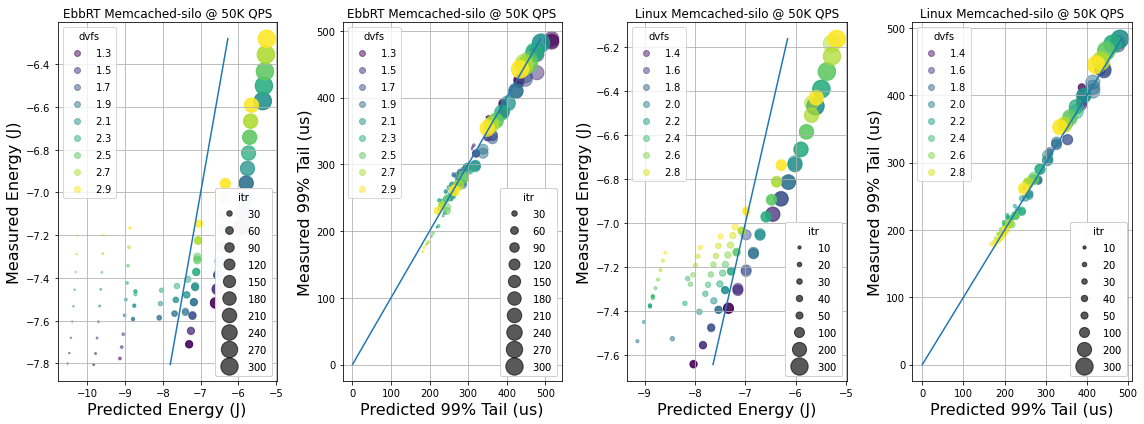

In [88]:
plt.rcParams['figure.figsize'] = 16, 6
run_energy(df_comb, n_iter=10000, lr=1, rqps=50000, rtail='99', 
           mpred=['energy', 'time'], msys=['ebbrt_tuned', 'linux_tuned'])

SYS ebbrt_tuned
mse_loss_time=0.6201902526874258 loss_time=0.78752 us zeta=124.9257583618164 alpha=1.2964670658111572 phi=0.5917387008666992


<ipython-input-86-2fd755f3a30f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:19: UserWarning: To copy construct fro

mse_loss_time=0.034591218549027754 loss_time=0.18599 us zeta=199.0268096923828 alpha=-1.1532318592071533 phi=0.8372260928153992
mse_loss_time=0.020588839470863356 loss_time=0.14349 us zeta=266.0412292480469 alpha=-0.8396839499473572 phi=0.8120812177658081
mse_loss_time=0.01256565234944531 loss_time=0.1121 us zeta=326.6261901855469 alpha=-0.610337495803833 phi=0.8015867471694946
mse_loss_time=0.007712427535763936 loss_time=0.08782 us zeta=382.781982421875 alpha=-0.42791682481765747 phi=0.7984515428543091
mse_loss_time=0.004825124643985077 loss_time=0.06946 us zeta=434.6590881347656 alpha=-0.27553239464759827 phi=0.7987238168716431
mse_loss_time=0.003227437049480078 loss_time=0.05681 us zeta=481.1071472167969 alpha=-0.1560964733362198 phi=0.8028275370597839
mse_loss_time=0.002475866302898427 loss_time=0.04976 us zeta=519.9154052734375 alpha=-0.061184562742710114 phi=0.8069775104522705


/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([120])) that is different to the input size (torch.Size([1, 120])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=194.5207101704154 loss_energy=13.947068156799672J gamma=1.4988617897033691 beta=1.8283369541168213
loss_energy=1.443746659071825 loss_energy=1.201560093824618J gamma=-8.380693435668945 beta=-3.144900321960449
loss_energy=1.2779554992333062 loss_energy=1.1304669385848072J gamma=-9.89204216003418 beta=-1.2982559204101562
loss_energy=1.2750287032792191 loss_energy=1.1291716890177592J gamma=-10.115682601928711 beta=-1.024998664855957
loss_energy=1.2750268994251934 loss_energy=1.1291708902664792J gamma=-10.121347427368164 beta=-1.0180764198303223
loss_energy=1.2750268993983294 loss_energy=1.1291708902545838J gamma=-10.121358871459961 beta=-1.0180630683898926
loss_energy=1.2750268993884193 loss_energy=1.1291708902501956J gamma=-10.121366500854492 beta=-1.0180541276931763
loss_energy=1.2750268993858493 loss_energy=1.1291708902490576J gamma=-10.121370315551758 beta=-1.0180494785308838
measurement tensor(-7.3890, dtype=torch.float64) tensor(0.5563, dtype=torch.float64)
measurement t

<ipython-input-86-2fd755f3a30f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:19: UserWarning: To copy construct fro

mse_loss_time=0.01384327388869347 loss_time=0.11766 us zeta=274.3163757324219 alpha=-0.7436586618423462 phi=0.928888201713562
mse_loss_time=0.009505535946927872 loss_time=0.0975 us zeta=335.20050048828125 alpha=-0.5382591485977173 phi=0.9052091240882874
mse_loss_time=0.006449914246384198 loss_time=0.08031 us zeta=396.58953857421875 alpha=-0.3636426031589508 phi=0.8872371315956116
mse_loss_time=0.004373626046026039 loss_time=0.06613 us zeta=456.42462158203125 alpha=-0.21594147384166718 phi=0.8738256096839905
mse_loss_time=0.0030029694510895436 loss_time=0.0548 us zeta=513.86376953125 alpha=-0.08995487540960312 phi=0.8638300895690918
mse_loss_time=0.0021531552695119994 loss_time=0.0464 us zeta=567.2172241210938 alpha=0.016170112416148186 phi=0.8564781546592712
mse_loss_time=0.0016735284866313401 loss_time=0.04091 us zeta=614.605712890625 alpha=0.102992482483387 phi=0.8513789772987366


/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([1, 104])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=130.85362438512513 loss_energy=11.439126906592353J gamma=0.37222933769226074 beta=-0.1968533992767334
loss_energy=0.7808529686107424 loss_energy=0.8836588530709928J gamma=-8.760951042175293 beta=-2.746077299118042
loss_energy=0.40526530231313884 loss_energy=0.636604510126294J gamma=-11.651817321777344 beta=0.5054211020469666
loss_energy=0.3847397217902826 loss_energy=0.6202739086809009J gamma=-12.447798728942871 beta=1.4007035493850708
loss_energy=0.38464312232655234 loss_energy=0.6201960354005436J gamma=-12.505709648132324 beta=1.4658387899398804
loss_energy=0.3846431130696183 loss_energy=0.6201960279376338J gamma=-12.50625991821289 beta=1.4664568901062012
loss_energy=0.38464311305830423 loss_energy=0.6201960279285125J gamma=-12.506271362304688 beta=1.4664701223373413
loss_energy=0.3846431130552454 loss_energy=0.6201960279260464J gamma=-12.506278038024902 beta=1.4664775133132935
measurement tensor(-7.2035, dtype=torch.float64) tensor(0.5070, dtype=torch.float64)
measuremen

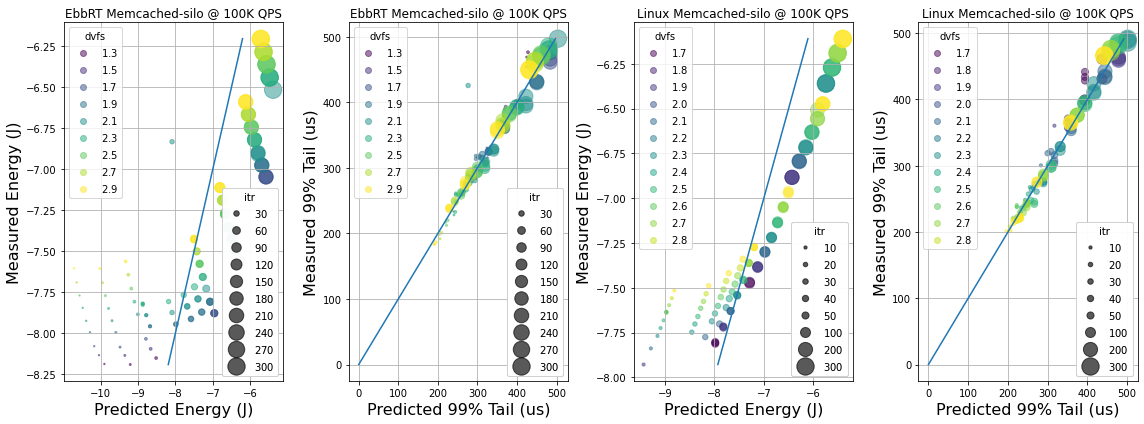

In [89]:
run_energy(df_comb, n_iter=8000, lr=.1, rqps=100000, rtail='99', 
           mpred=['energy', 'time'], msys=['ebbrt_tuned', 'linux_tuned'])

SYS ebbrt_tuned
mse_loss_time=0.7063962132539772 loss_time=0.84047 us zeta=58.75666427612305 alpha=0.4095919132232666 phi=0.4501851797103882


<ipython-input-86-2fd755f3a30f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:19: UserWarning: To copy construct fro

mse_loss_time=0.05258496150790794 loss_time=0.22931 us zeta=119.68704223632812 alpha=-1.7928632497787476 phi=0.7653049230575562
mse_loss_time=0.037903563303001694 loss_time=0.19469 us zeta=178.44497680664062 alpha=-1.3998749256134033 phi=0.7265582084655762
mse_loss_time=0.028653752967152106 loss_time=0.16927 us zeta=235.4379119873047 alpha=-1.122263789176941 phi=0.7052175402641296
mse_loss_time=0.022066000569903876 loss_time=0.14855 us zeta=293.00311279296875 alpha=-0.9001413583755493 phi=0.6923113465309143
mse_loss_time=0.01711212282671693 loss_time=0.13081 us zeta=352.0680847167969 alpha=-0.7109043598175049 phi=0.6843900084495544
mse_loss_time=0.013514371016960498 loss_time=0.11625 us zeta=412.8857421875 alpha=-0.5608503818511963 phi=0.6902008652687073
mse_loss_time=0.01034085348416501 loss_time=0.10169 us zeta=475.2510681152344 alpha=-0.39682334661483765 phi=0.6781690120697021
mse_loss_time=0.008076851267400981 loss_time=0.08987 us zeta=538.729248046875 alpha=-0.2592134177684784 phi

/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([117])) that is different to the input size (torch.Size([1, 117])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=132.26405152130178 loss_energy=11.500610919481703J gamma=0.24812674522399902 beta=0.595555305480957
loss_energy=2.366172669481497 loss_energy=1.5382368704076421J gamma=-7.627729892730713 beta=-3.2790396213531494
loss_energy=2.154213232121057 loss_energy=1.467723826924213J gamma=-9.891667366027832 beta=-0.7962259650230408
loss_energy=2.1274531413060354 loss_energy=1.4585791515396191J gamma=-10.884321212768555 beta=0.29239726066589355
loss_energy=2.126915760525779 loss_energy=1.4583949261176752J gamma=-11.040889739990234 beta=0.4641020894050598
loss_energy=2.1269151306024123 loss_energy=1.4583947101530548J gamma=-11.046404838562012 beta=0.47015172243118286
loss_energy=2.1269151305868457 loss_energy=1.4583947101477177J gamma=-11.04642105102539 beta=0.47016939520835876
loss_energy=2.1269151305839085 loss_energy=1.4583947101467107J gamma=-11.046426773071289 beta=0.4701755940914154
loss_energy=2.126915130582066 loss_energy=1.458394710146079J gamma=-11.04643440246582 beta=0.470183

<ipython-input-86-2fd755f3a30f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zeta = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-86-2fd755f3a30f>:19: UserWarning: To copy construct fro

mse_loss_time=0.019929630491325675 loss_time=0.14117 us zeta=210.9813995361328 alpha=-1.4780915975570679 phi=0.6359609961509705
mse_loss_time=0.01772182487312631 loss_time=0.13312 us zeta=253.4729461669922 alpha=-1.3016544580459595 phi=0.6178131103515625
mse_loss_time=0.01560013120309461 loss_time=0.1249 us zeta=305.685302734375 alpha=-1.121045470237732 phi=0.6004408597946167
mse_loss_time=0.013739955767639428 loss_time=0.11722 us zeta=364.3681640625 alpha=-0.9512237906455994 phi=0.5852888822555542
mse_loss_time=0.012171423387612868 loss_time=0.11032 us zeta=427.0919189453125 alpha=-0.79744553565979 phi=0.5726999640464783
mse_loss_time=0.010879135853166714 loss_time=0.1043 us zeta=491.48291015625 alpha=-0.6606760025024414 phi=0.5621813535690308
mse_loss_time=0.00980667778089382 loss_time=0.09903 us zeta=556.9212646484375 alpha=-0.5389081835746765 phi=0.5536491274833679
mse_loss_time=0.008908985367173982 loss_time=0.09439 us zeta=623.0147094726562 alpha=-0.4293878376483917 phi=0.5465350

/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([75])) that is different to the input size (torch.Size([1, 75])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_energy=156.53206452482686 loss_energy=12.511277493718492J gamma=0.34488630294799805 beta=1.4379456043243408
loss_energy=0.3158698005582037 loss_energy=0.562022953764527J gamma=-6.370461940765381 beta=-4.369227886199951
loss_energy=0.27661806944211764 loss_energy=0.5259449300469752J gamma=-7.347050189971924 beta=-3.389430522918701
loss_energy=0.2332069954295604 loss_energy=0.4829151016789187J gamma=-8.719482421875 beta=-2.012488603591919
loss_energy=0.20102864553473876 loss_energy=0.4483621812048143J gamma=-10.247498512268066 beta=-0.4794517755508423
loss_energy=0.1872637262251068 loss_energy=0.43273979043428257J gamma=-11.51304817199707 beta=0.790255606174469
loss_energy=0.1847046957126514 loss_energy=0.42977284199057J gamma=-12.181934356689453 beta=1.461340308189392
loss_energy=0.18457346476815378 loss_energy=0.42962014008674426J gamma=-12.356884956359863 beta=1.636865258216858
loss_energy=0.18457259800161746 loss_energy=0.42961913132636154J gamma=-12.37208080291748 beta=1.652111

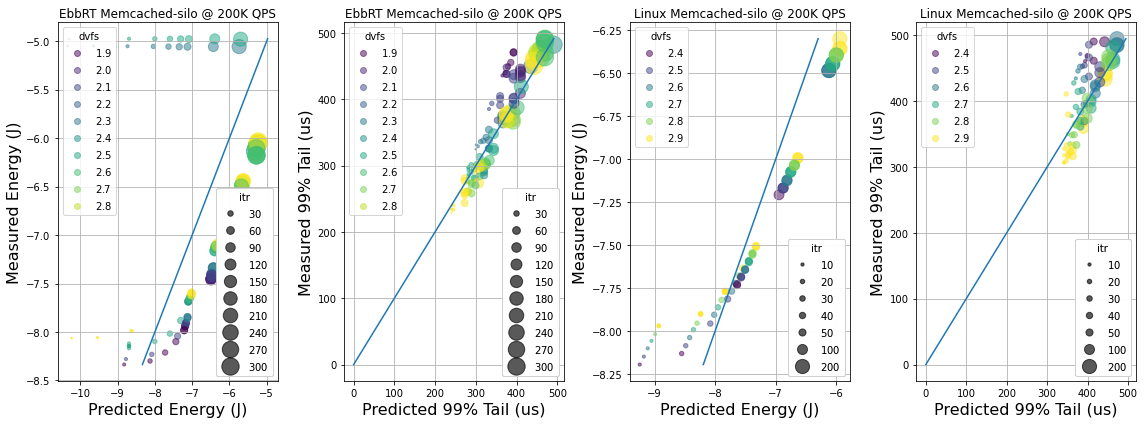

In [93]:
run_energy(df_comb, n_iter=10000, lr=.1, rqps=200000, rtail='99', 
           mpred=['energy', 'time'], msys=['ebbrt_tuned', 'linux_tuned'])

In [95]:
print(math.exp(-12.89), math.exp(-12))

2.5231561490262545e-06 6.14421235332821e-06


SYS ebbrt_tuned


<ipython-input-243-d0941bd06faa>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-243-d0941bd06faa>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-243-d0941bd06faa>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-243-d0941bd06faa>:19: UserWarning: To copy const

loss_energy 650023.282771559 -0.9005858898162842
loss_energy 1781.3906453932466 288.5133361816406
loss_energy 1781.3704988446007 288.5961608886719
loss_energy 1781.37049804096 288.596435546875
loss_energy 1781.3704977830323 288.5965881347656
loss_energy 1782.110535853954 288.595458984375
loss_energy 1781.3704976513366 288.5967712402344
SYS linux_tuned
loss_energy 618320.9215949354 -1.3064892292022705
loss_energy 1158.7568419057247 388.2728576660156
loss_energy 1145.158582090512 390.5665283203125
loss_energy 1145.158580522677 390.5669250488281
loss_energy 1145.1585840246396 390.5675048828125
loss_energy 1145.3135048206834 390.5669250488281
loss_energy 1198.5300801030876 390.58154296875


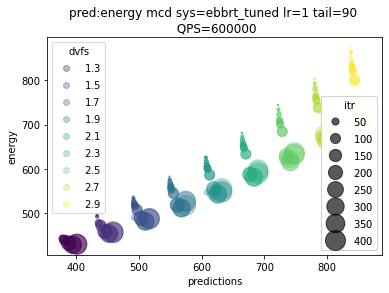

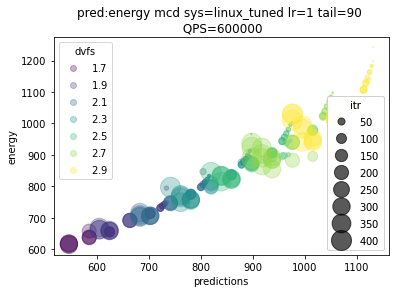

In [247]:
run_energy(df_comb, n_iter=7000, lr=1, rqps=600000, rtail='90', 
           mpred=['energy'], msys=['ebbrt_tuned', 'linux_tuned'])

SYS ebbrt_tuned


<ipython-input-237-315dd66995e6>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-237-315dd66995e6>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-237-315dd66995e6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-237-315dd66995e6>:19: UserWarning: To copy const

loss_energy 920247.299989853 -1.836015224456787
loss_energy 8542.277643926016 422.97113037109375
loss_energy 8442.651885842135 427.45745849609375
loss_energy 8442.651882791135 427.45782470703125
loss_energy 8442.651881373737 427.4580993652344
loss_energy 8442.651880908845 427.458251953125
loss_energy 8442.651880740501 427.4583435058594
SYS linux_tuned
loss_energy 1624253.6814025042 1.827260971069336
loss_energy 21957.93905157295 552.2310180664062
loss_energy 16744.13391287446 585.412353515625
loss_energy 16744.118224289323 585.4678955078125
loss_energy 16744.11821034165 585.46875
loss_energy 16744.11820501437 585.4692993164062
loss_energy 16744.118203285358 585.4696044921875


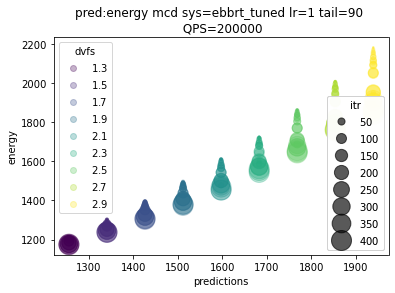

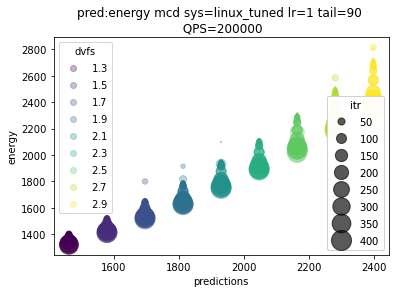

In [240]:
run_energy(df_comb, n_iter=7000, lr=1, rqps=200000, rtail='90', 
           mpred=['energy'], msys=['ebbrt_tuned', 'linux_tuned'])

SYS ebbrt_tuned


<ipython-input-237-315dd66995e6>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-237-315dd66995e6>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-237-315dd66995e6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-237-315dd66995e6>:19: UserWarning: To copy const

loss_energy 55837.02530966488 -1.1267814636230469
loss_energy 14591.49312039786 90.1004867553711
loss_energy 14591.49312039786 90.1004867553711
loss_energy 14591.493120396959 90.10047912597656
loss_energy 14591.493120396959 90.10047912597656
loss_energy 14591.493120396632 90.10047149658203
loss_energy 14591.493120396632 90.10047149658203
loss_energy 14591.493120396632 90.10047149658203
SYS linux_tuned
loss_energy 198472.27790596543 -0.3984062671661377
loss_energy 16725.156715829336 193.77761840820312
loss_energy 16725.156715721296 193.77767944335938
loss_energy 16725.15671564918 193.77774047851562
loss_energy 16725.156715618654 193.7777862548828
loss_energy 16725.156715612968 193.77780151367188
loss_energy 16725.15671560953 193.77781677246094
loss_energy 16725.15671560833 193.77783203125


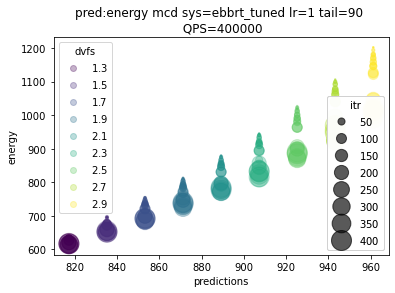

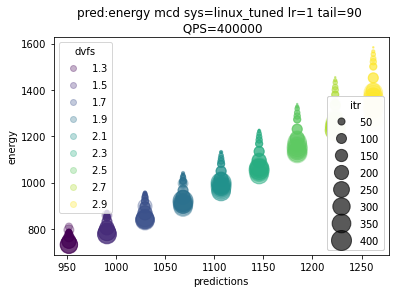

In [241]:
run_energy(df_comb, n_iter=8000, lr=1, rqps=400000, rtail='90', 
           mpred=['energy'], msys=['ebbrt_tuned', 'linux_tuned'])

SYS ebbrt_tuned


<ipython-input-237-315dd66995e6>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-237-315dd66995e6>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-237-315dd66995e6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-237-315dd66995e6>:19: UserWarning: To copy const

loss_energy 20526.91971893835 -0.07694077491760254
loss_energy 17282.64256848035 -25.68421745300293
loss_energy 17282.64256848035 -25.68421745300293
loss_energy 17282.64256848035 -25.68421745300293
loss_energy 17282.64256848035 -25.68421745300293
loss_energy 17282.64256848035 -25.68421745300293
loss_energy 17282.64256848037 -25.684219360351562
loss_energy 17282.64256848037 -25.684219360351562
SYS linux_tuned
loss_energy 46337.521686803106 1.054931402206421
loss_energy 13646.841189580799 76.79198455810547
loss_energy 13646.841189580799 76.79198455810547
loss_energy 13646.841189579627 76.7919921875
loss_energy 13646.841189579121 76.79199981689453
loss_energy 13646.841189579121 76.79199981689453
loss_energy 13646.841189579121 76.79199981689453
loss_energy 13646.841189579121 76.79199981689453


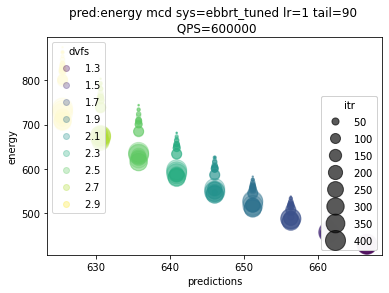

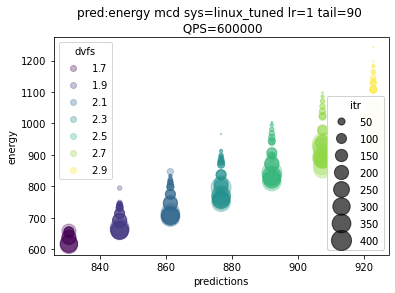

In [242]:
run_energy(df_comb, n_iter=8000, lr=1, rqps=600000, rtail='90', 
           mpred=['energy'], msys=['ebbrt_tuned', 'linux_tuned'])

In [49]:
def run_time(df_comb, n_iter=2000, lr=1, rqps=400000, rtail='99', msys=['ebbrt_tuned']):       
    df_comb = df_comb[df_comb['QPS'] == rqps]

    for sys in msys:
        df = df_comb[(df_comb['sys']==sys)].copy()
        rt = 'read_'+rtail+'th_mean'
        df = df[['joules_mean','itr', 'dvfs', 'QPS', rt]]
        d = df.values
        d = torch.tensor(d)
        #plt.plot(d[:,0], d[:,1], 'p')

        pred_time, max_time, alpha, itr_suppress = inference_time(d, n_iter, lr, 'mcd', sys, print_freq=1000)
        tnum = 0
        if rqps == 200000:
            if sys == 'linux_tuned':
                tnum=345
            else:
                tnum=246
        elif rqps == 400000:
            if sys == 'linux_tuned':
                tnum=318
                #df[f'pre_energy lr={lr}'] = pred_energy.view(318, 1).detach().numpy()
                #df[f'pre_time lr={lr}'] = pred_time.view(318, 1).detach().numpy()
            else:
                tnum=245
                #df[f'pre_energy lr={lr}'] = pred_energy.view(245, 1).detach().numpy()
                #df[f'pre_time lr={lr}'] = pred_time.view(245, 1).detach().numpy()
        if rqps == 600000:
            if sys == 'linux_tuned':
                tnum=202
            else:
                tnum=246
        df[f'pre_time lr={lr}'] = pred_time.view(tnum, 1).detach().numpy()

#             for pred_name in ['time', 'energy']:
#                 if pred_name == 'energy':
#                     pred = pred_energy
#                     qps = d[:,3]
#                     yvalue = d[:,0]/(qps*20)
#                 else:
        pred = pred_time
        yvalue = d[:,4]
        fig, ax = plt.subplots()
        plt.title(f'pred:time mcd sys={sys} lr={lr} tail={rtail} \n QPS={rqps} max_time={round(max_time.item(),2)} \n alpha={round(alpha.item(),2)} itr_suppress={round(itr_suppress.item(),2)}')
        plt.xlabel(u"predictions")
        plt.ylabel('time')
        scatter = ax.scatter(pred.detach().numpy()[0], yvalue, marker = 'o', s = d[:,1], c = d[:,2], alpha=0.3)
        legend1 = ax.legend(*scatter.legend_elements(),loc="upper left", title="dvfs")
        ax.add_artist(legend1)
        handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
        legend2 = plt.legend(handles, labels, loc="lower right", title="itr")
        ax.add_artist(legend2)
        
run_time(df_comb, rqps=200000, rtail='90')
run_time(df_comb, rqps=400000, rtail='90')
run_time(df_comb, rqps=600000, rtail='90')

<ipython-input-7-f94ae881036c>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-7-f94ae881036c>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-7-f94ae881036c>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-7-f94ae881036c>:19: UserWarning: To copy construct fro

429.2119140625 -0.5882140398025513 -0.9464408159255981 35.02513128982781
211.00961303710938 3.6269314289093018 0.9249256253242493 0.24131148425789484


KeyboardInterrupt: 

<ipython-input-47-3514657f030e>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(10, 500), requires_grad=True)
<ipython-input-47-3514657f030e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-47-3514657f030e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-47-3514657f030e>:19: UserWarning: To copy construct

AttributeError: 'float' object has no attribute 'item'

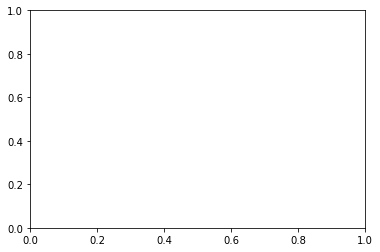